# Setting Up the Python Environment

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

from src.utils import lorenz_3d_plotter, lorenz_ts_plotter, lorenz_ts_train_target_compare

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"

# Modeling Lorenz System

In [38]:
def lorenz(t, vars, rho, sigma, beta):
    x, y, z = vars

    variable_vector = np.array([x, y, z, x*z, x*y])

    weights = np.array([[-sigma, sigma, 0, 0, 0],
                         [rho, -1, 0, -1, 0],
                         [0, 0, -beta, 0, 1]])

    return weights@variable_vector


rho = 27.999999
sigma = 9.99999999
beta = 8/3


t_start = 0
t_stop = 250

dt = 0.01

t_span = [t_start, t_stop]
t_eval = np.arange(t_start, t_stop, dt)
initial_conditions = [np.random.rand(), 1, 1]

lorenz_soln = solve_ivp(lorenz, t_span, initial_conditions, t_eval= t_eval, args=(rho, sigma, beta))


time = lorenz_soln.t
x = lorenz_soln.y[0, :]
y = lorenz_soln.y[1, :]
z = lorenz_soln.y[2, :]

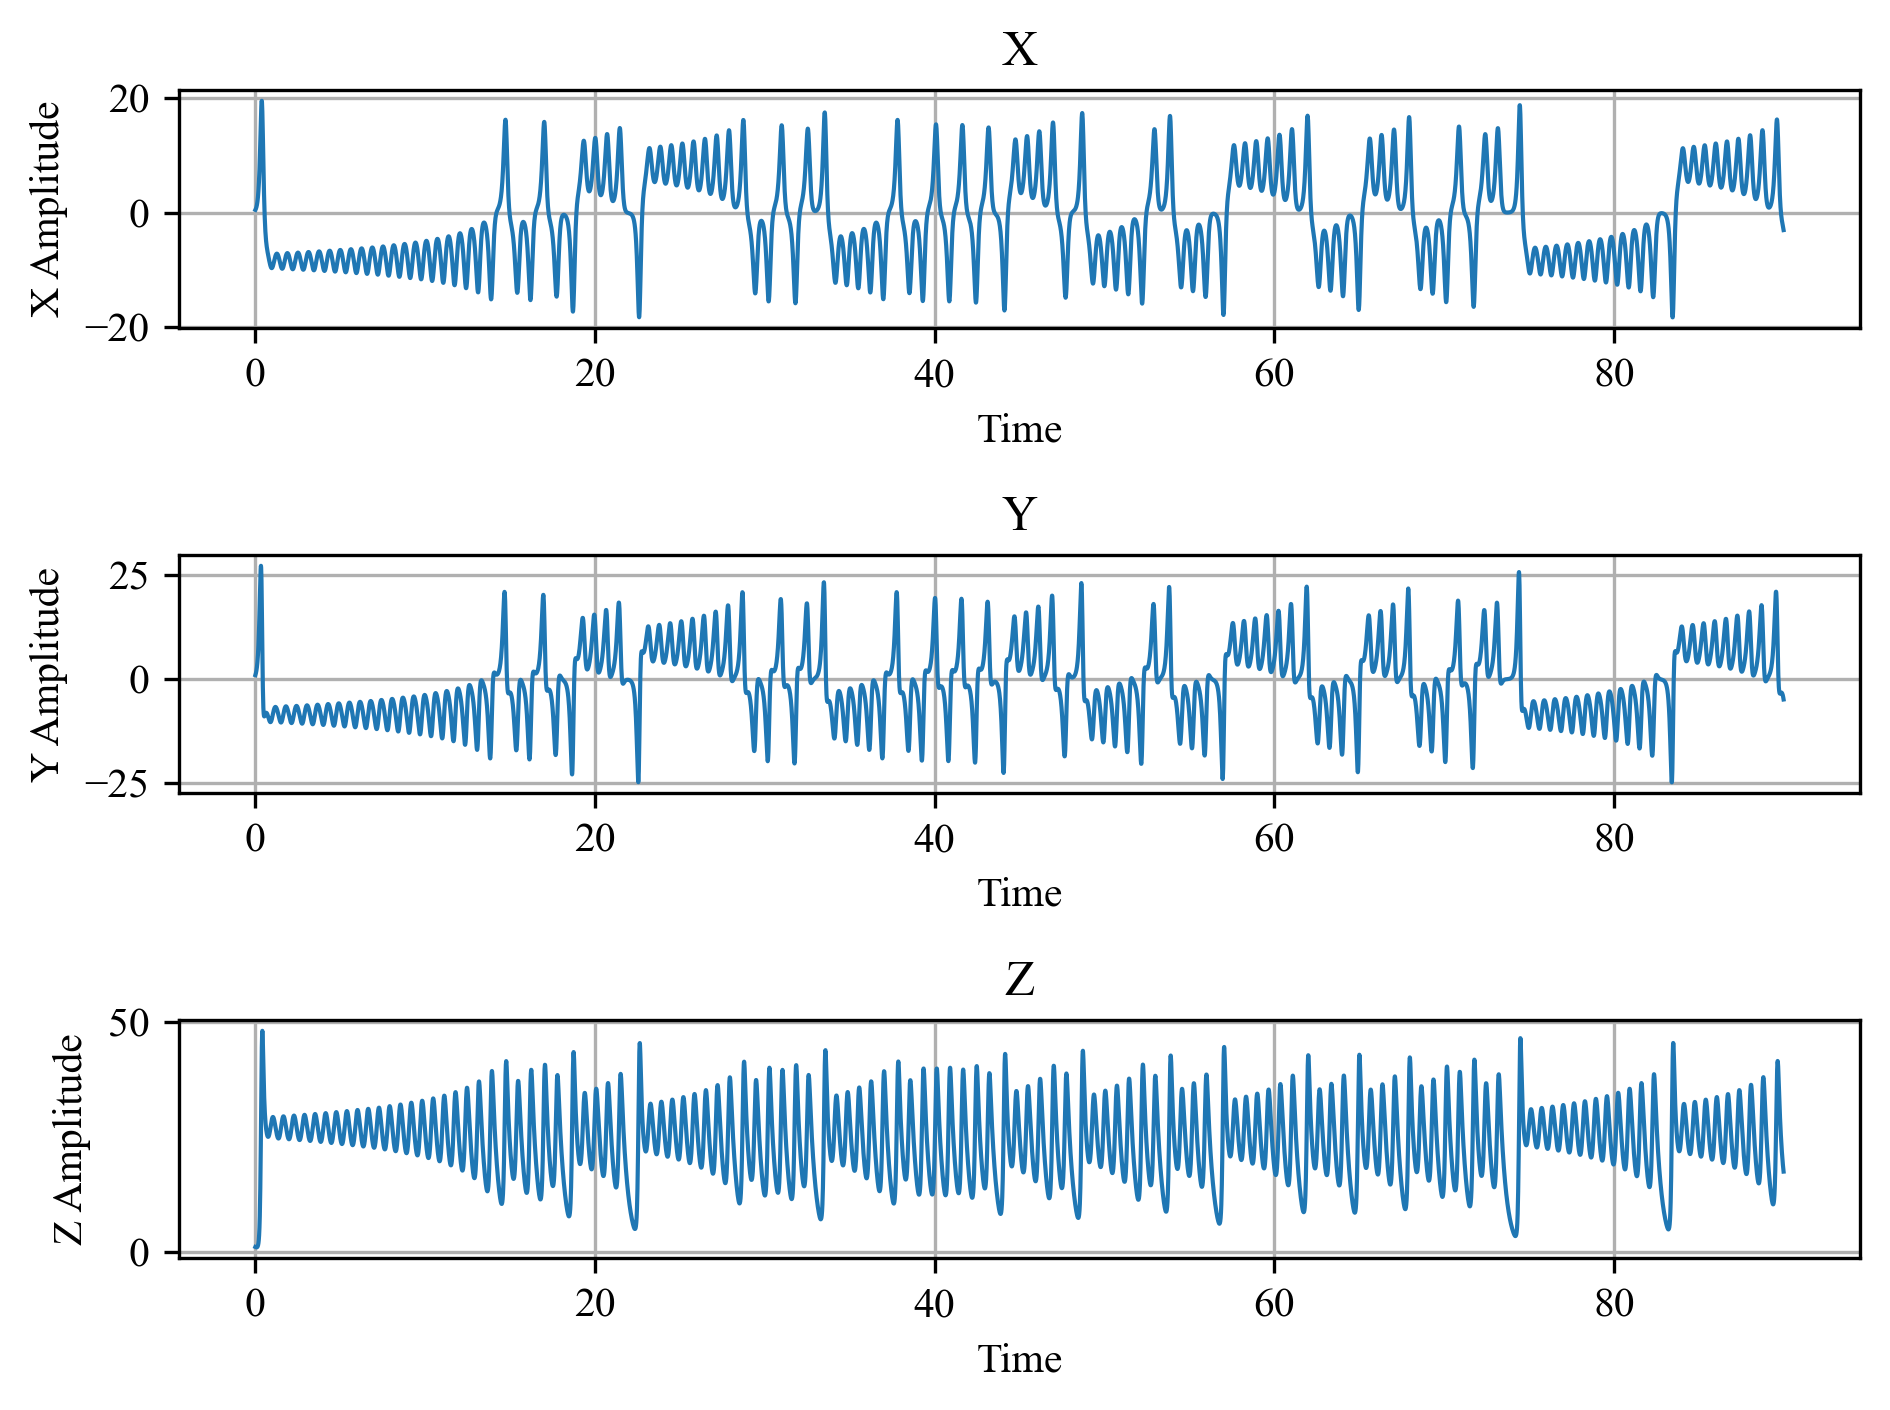

In [39]:
lorenz_ts_plotter(x, y, z, time, num_points_to_plot=9000)

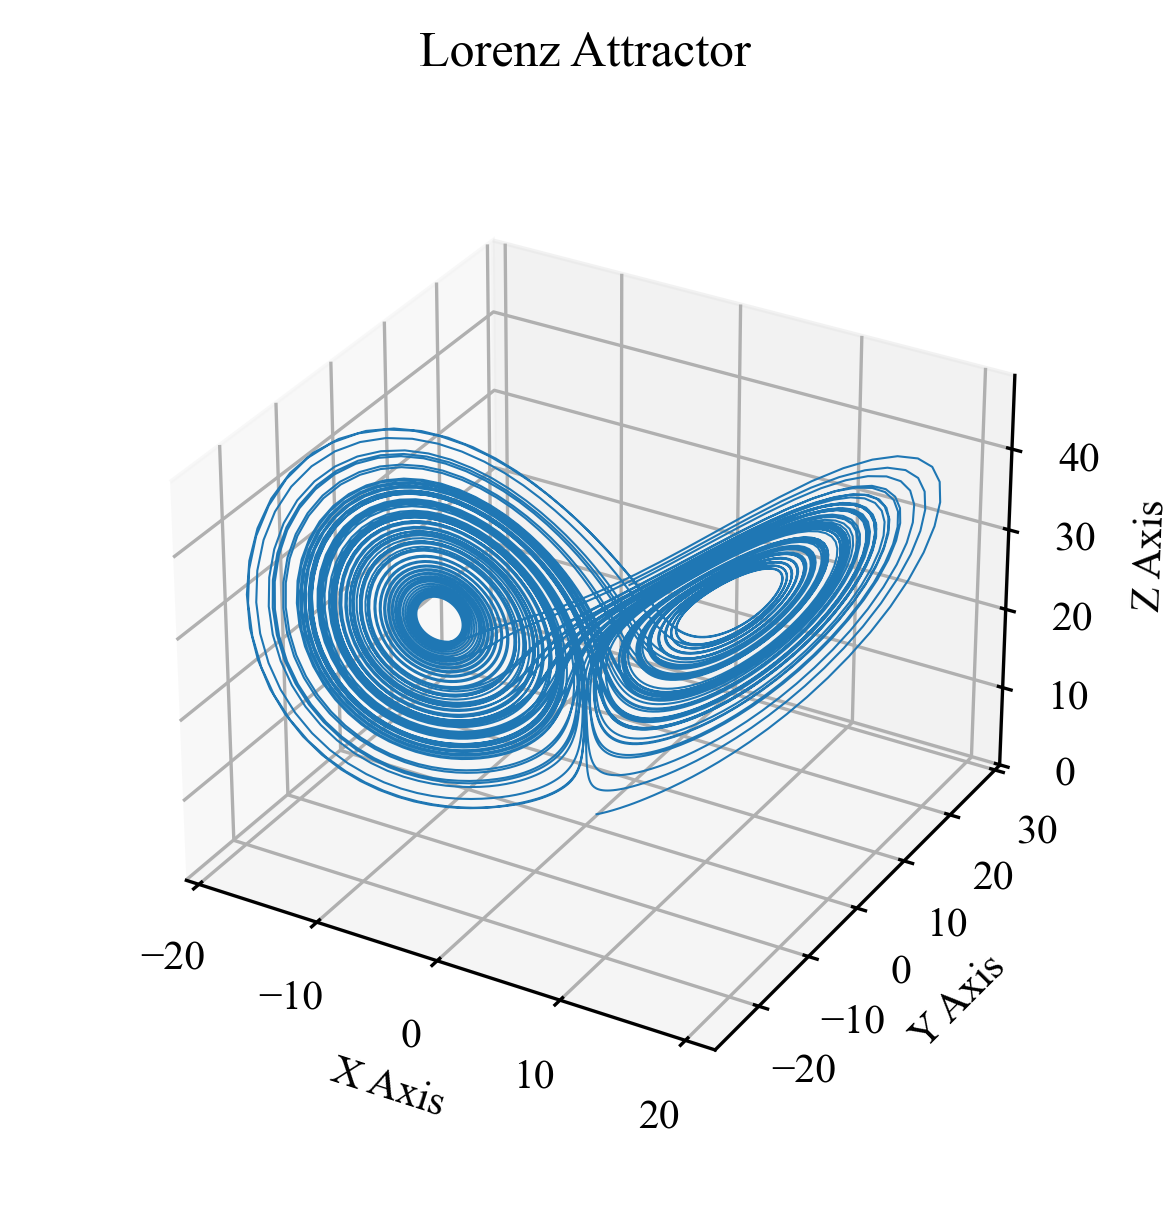

In [40]:
lorenz_3d_plotter(x, y, z, num_points_to_plot=10000)

# Processing Training Data

In [41]:
# Start out by determining the scaling factor for the different channels

x_scaling_factor = np.abs(np.max(x))
y_scaling_factor = np.abs(np.max(y))
z_scaling_factor = np.abs(np.max(z))

x_amp_shift = np.mean(x)
y_amp_shift = np.mean(y)
z_amp_shift = np.mean(z)

print("X Scaling: ", x_scaling_factor)
print("Y Scaling: ", y_scaling_factor)
print("Z Scaling: ", z_scaling_factor)

lorenz_data = np.copy(lorenz_soln.y)

lorenz_data[0, :] -= x_amp_shift
lorenz_data[1, :] -= y_amp_shift
lorenz_data[2, :] -= z_amp_shift

# Now apply the scaling factor to our data.
lorenz_data[0, :] /= x_scaling_factor
lorenz_data[1, :] /= y_scaling_factor
lorenz_data[2, :] /= z_scaling_factor




X Scaling:  19.575388632755974
Y Scaling:  27.26461097908086
Z Scaling:  48.013759831859915


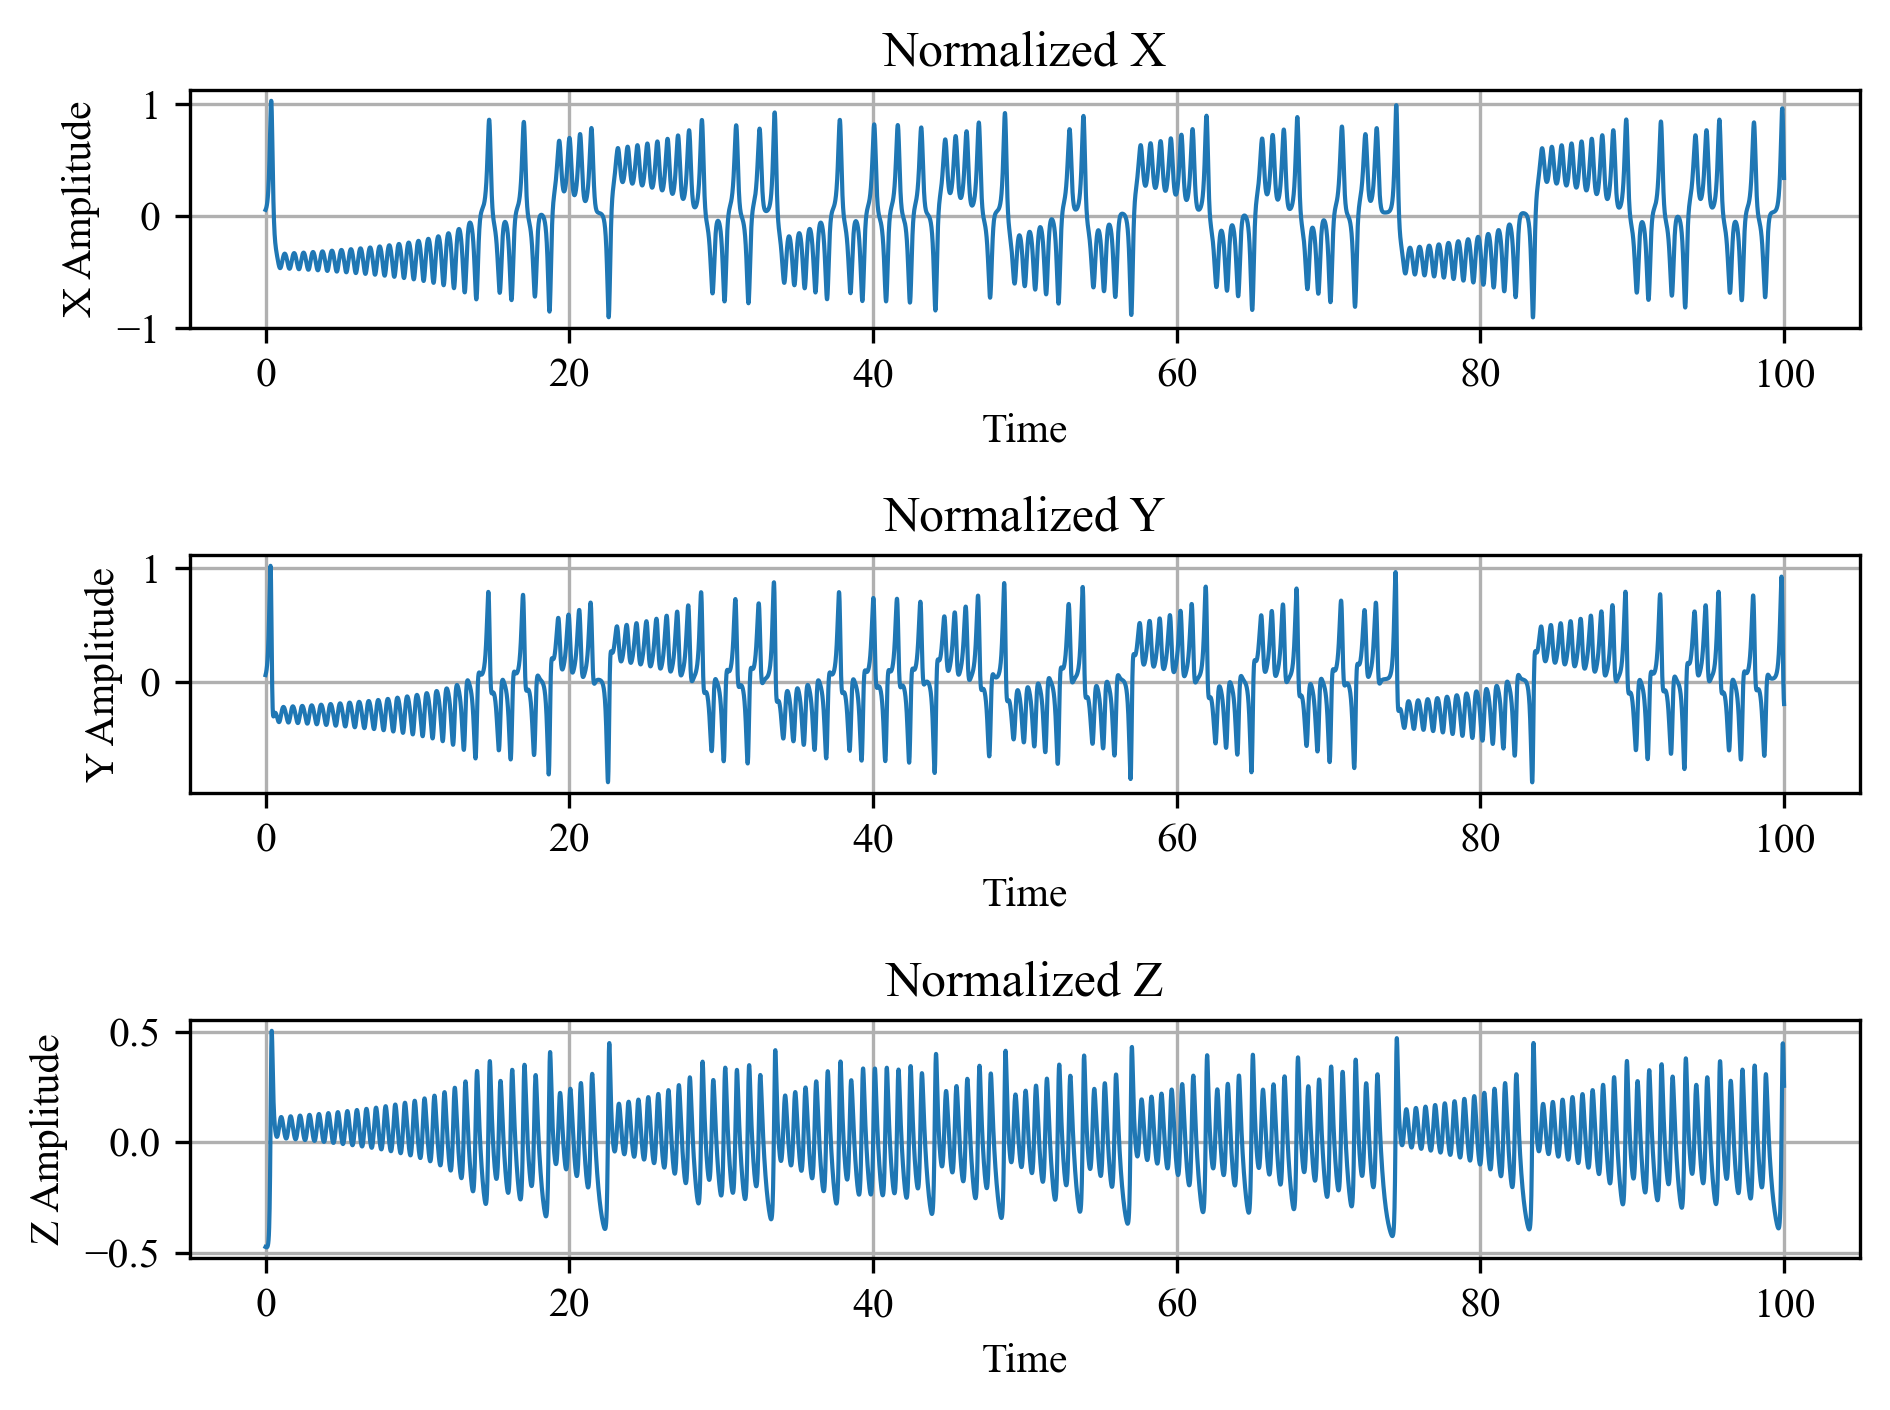

In [42]:
lorenz_ts_plotter(lorenz_data[0], lorenz_data[1], lorenz_data[2], time, num_points_to_plot=10000, title_prefix = "Normalized ")

In [43]:
num_training_points = 25000
lorenz_subset = lorenz_data[:, :num_training_points]


lorenz_training_data = np.copy(lorenz_subset[:, :-1])

lorenz_target_data = np.copy(lorenz_subset[:, 1:])

In [44]:
noise_magnitude = 0.05

training_noise = np.random.normal(0, noise_magnitude, np.shape(lorenz_training_data))

lorenz_training_data += training_noise

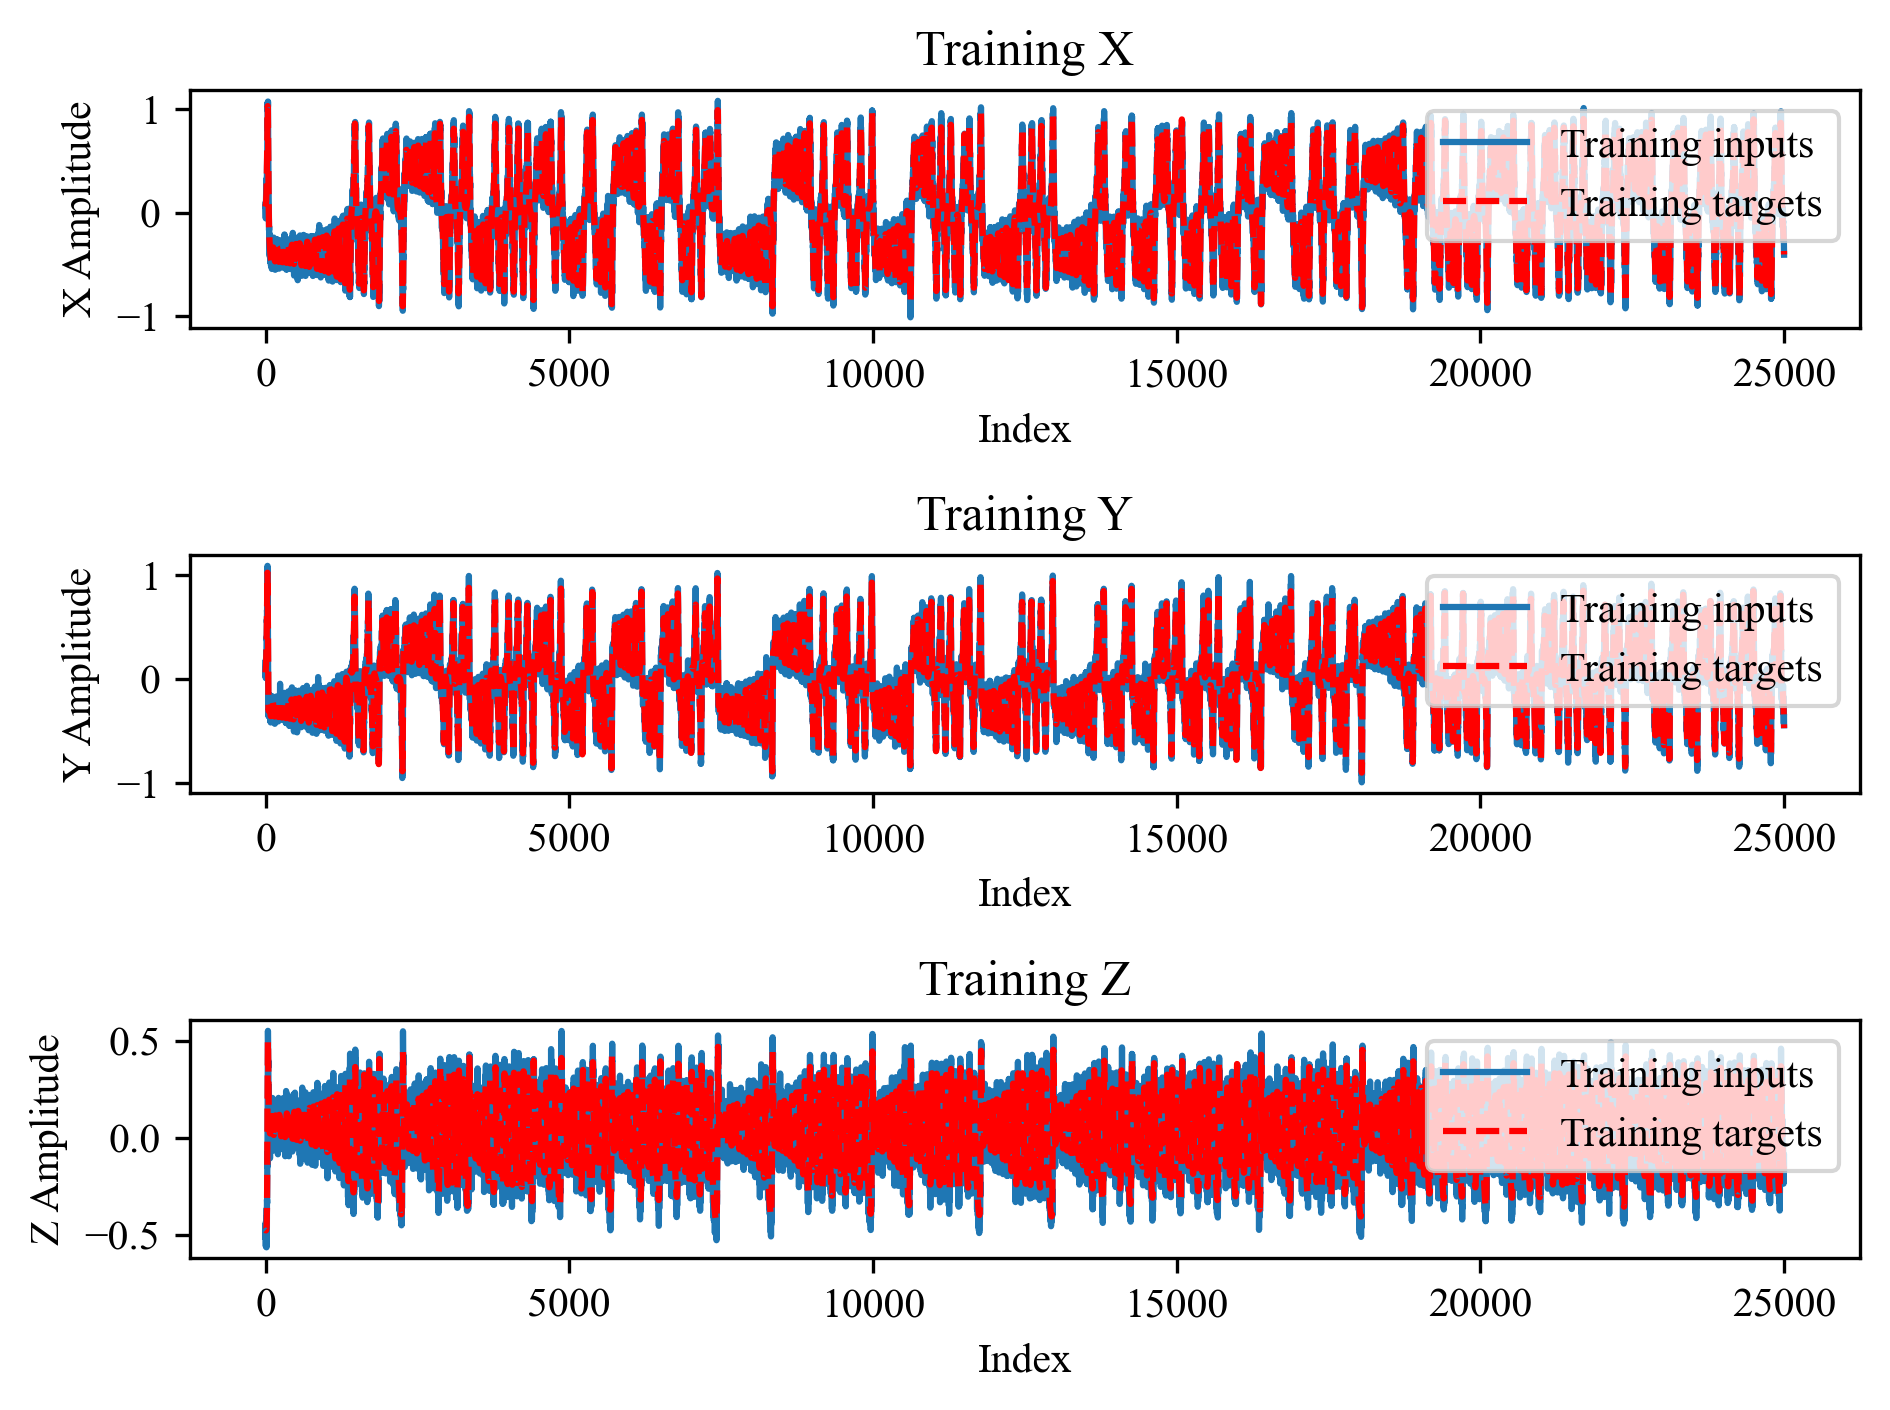

In [45]:
lorenz_ts_train_target_compare(lorenz_training_data, lorenz_target_data)

# Create Input and Reservoir Matrices


In [46]:
# These are our reservoir parameters
# After we finish feel free to play around with these to see how different 
# parameters affect the performance of the system

reservoir_size = 1000
input_size = 3
spectral_radius = 1
leaky_integrator_factor = 0.5
sparsity = 0.5
transient = 100

In [47]:
# First: Define the input matrix
input_weights = np.random.uniform(low = -1, high = 1, size = (reservoir_size, input_size)) 


# Second: Define the reservoir matrix
reservoir_weights = np.random.normal(0, 1, (reservoir_size, reservoir_size))

In [48]:
# Now we need to change the sparsity and spectral radius of our reservoir

# Start by changing the sparsity: 

# How big is our reservoir?
total_elements = np.size(reservoir_weights)

# use the given ratio to determine how many need to be zeros
number_to_zeros = int(sparsity*total_elements)

# now get the correct number of indicies
indices_to_set_to_zero = np.random.choice(total_elements, number_to_zeros, replace=False)

# flatten matrix into vector to make assignment easier
flat_matrix = reservoir_weights.flatten()

# set certain values to 0
flat_matrix[indices_to_set_to_zero] = 0

# turn vector back into matrix
reservoir_weights = flat_matrix.reshape(reservoir_weights.shape) 

In [49]:
# Now change the spectral radius of the reservoir: 

# start by calculating the current spectral radius: 
current_spectral_radius = np.max(np.abs(np.linalg.eigvals(reservoir_weights)))


# Now divide through. This creates a matrix with a spectral radius of 1
reservoir_weights = reservoir_weights / current_spectral_radius

# multiply by the desired spectral radius

reservoir_weights = spectral_radius * reservoir_weights

# Train Readout Matrix

In [50]:
# This is where we store our reservoir outputs
reservoir_states = np.zeros((np.shape(lorenz_training_data)[1], reservoir_size))

for i in range(1, np.shape(lorenz_training_data)[1]):
    previous_reservoir_state = reservoir_states[i-1, :]

    input_data = lorenz_training_data[:, i]

    # This is the equation for the leaky integrator reservoir computer

    # x(t) = (1-a)x(t-1) + a*tanh(W_in*u(t) + W_r*x(t-1))
    reservoir_states[i, :] = ((1-leaky_integrator_factor)*previous_reservoir_state 
                                + leaky_integrator_factor*np.tanh(input_weights@input_data 
                                + reservoir_weights@previous_reservoir_state))



# We initialized our reservoir randomly, so we want to ignore the warmup period
# this figure is useful to illustrate why exactly we need to get rid of the transient
reservoir_states = reservoir_states[transient:, :]
lorenz_target_data = lorenz_target_data[:, transient:]

In [51]:
# Take the pseudo inverse of the reservoir states
S_cross = np.linalg.pinv(reservoir_states)

# Multiply the pseudo inverse with the target outputs to determine the readout weights 
readout_weights = (S_cross@lorenz_target_data.T).T

# Create Feedback Loop and Generate Output

In [52]:
# For this example, let's graph the last point in our training data and use this as our starting point. 
# We could also grab any other point in our lorenz system.
# initial_conditions = lorenz_target_data[:, 1234]

# initial_conditions = np.random.normal(0, 1, [3, ])

initial_conditions = np.random.normal(0, 1, [3, ])



print(np.shape(initial_conditions))

num_steps_to_generate = 10000

output = np.zeros([num_steps_to_generate, input_size])

output[0, :] = initial_conditions

inference_reservoir_states = np.zeros((num_steps_to_generate, reservoir_size))
inference_reservoir_states[0, :] = reservoir_states[-1, :]



for i in np.arange(1, num_steps_to_generate):
    # take the predicted outputs and feed them back into the input 
    # Note that we put our initial conditions in the output vector, 
    # so for the first run, we will just pull the initial conditions 
    current_input = output[i-1, :] 

    previous_reservoir_state = inference_reservoir_states[i-1, :]
    

    # now step the reservoir forwards
    inference_reservoir_states[i, :] = ((1-leaky_integrator_factor)*previous_reservoir_state 
                                + leaky_integrator_factor*np.tanh(input_weights@current_input 
                                + reservoir_weights@previous_reservoir_state))



    # Use the state of the reservoir and the readout weights to get the   predicted output. 
    output[i, :] = (readout_weights@inference_reservoir_states[i, :])
    # print(predictions[i, :])


properly_scaled_output = output.T

properly_scaled_output[0, :] *= x_scaling_factor
properly_scaled_output[1, :] *= y_scaling_factor
properly_scaled_output[2, :] *= z_scaling_factor

properly_scaled_output[0, :] += x_amp_shift
properly_scaled_output[1, :] += y_amp_shift
properly_scaled_output[2, :] += z_amp_shift


(3,)


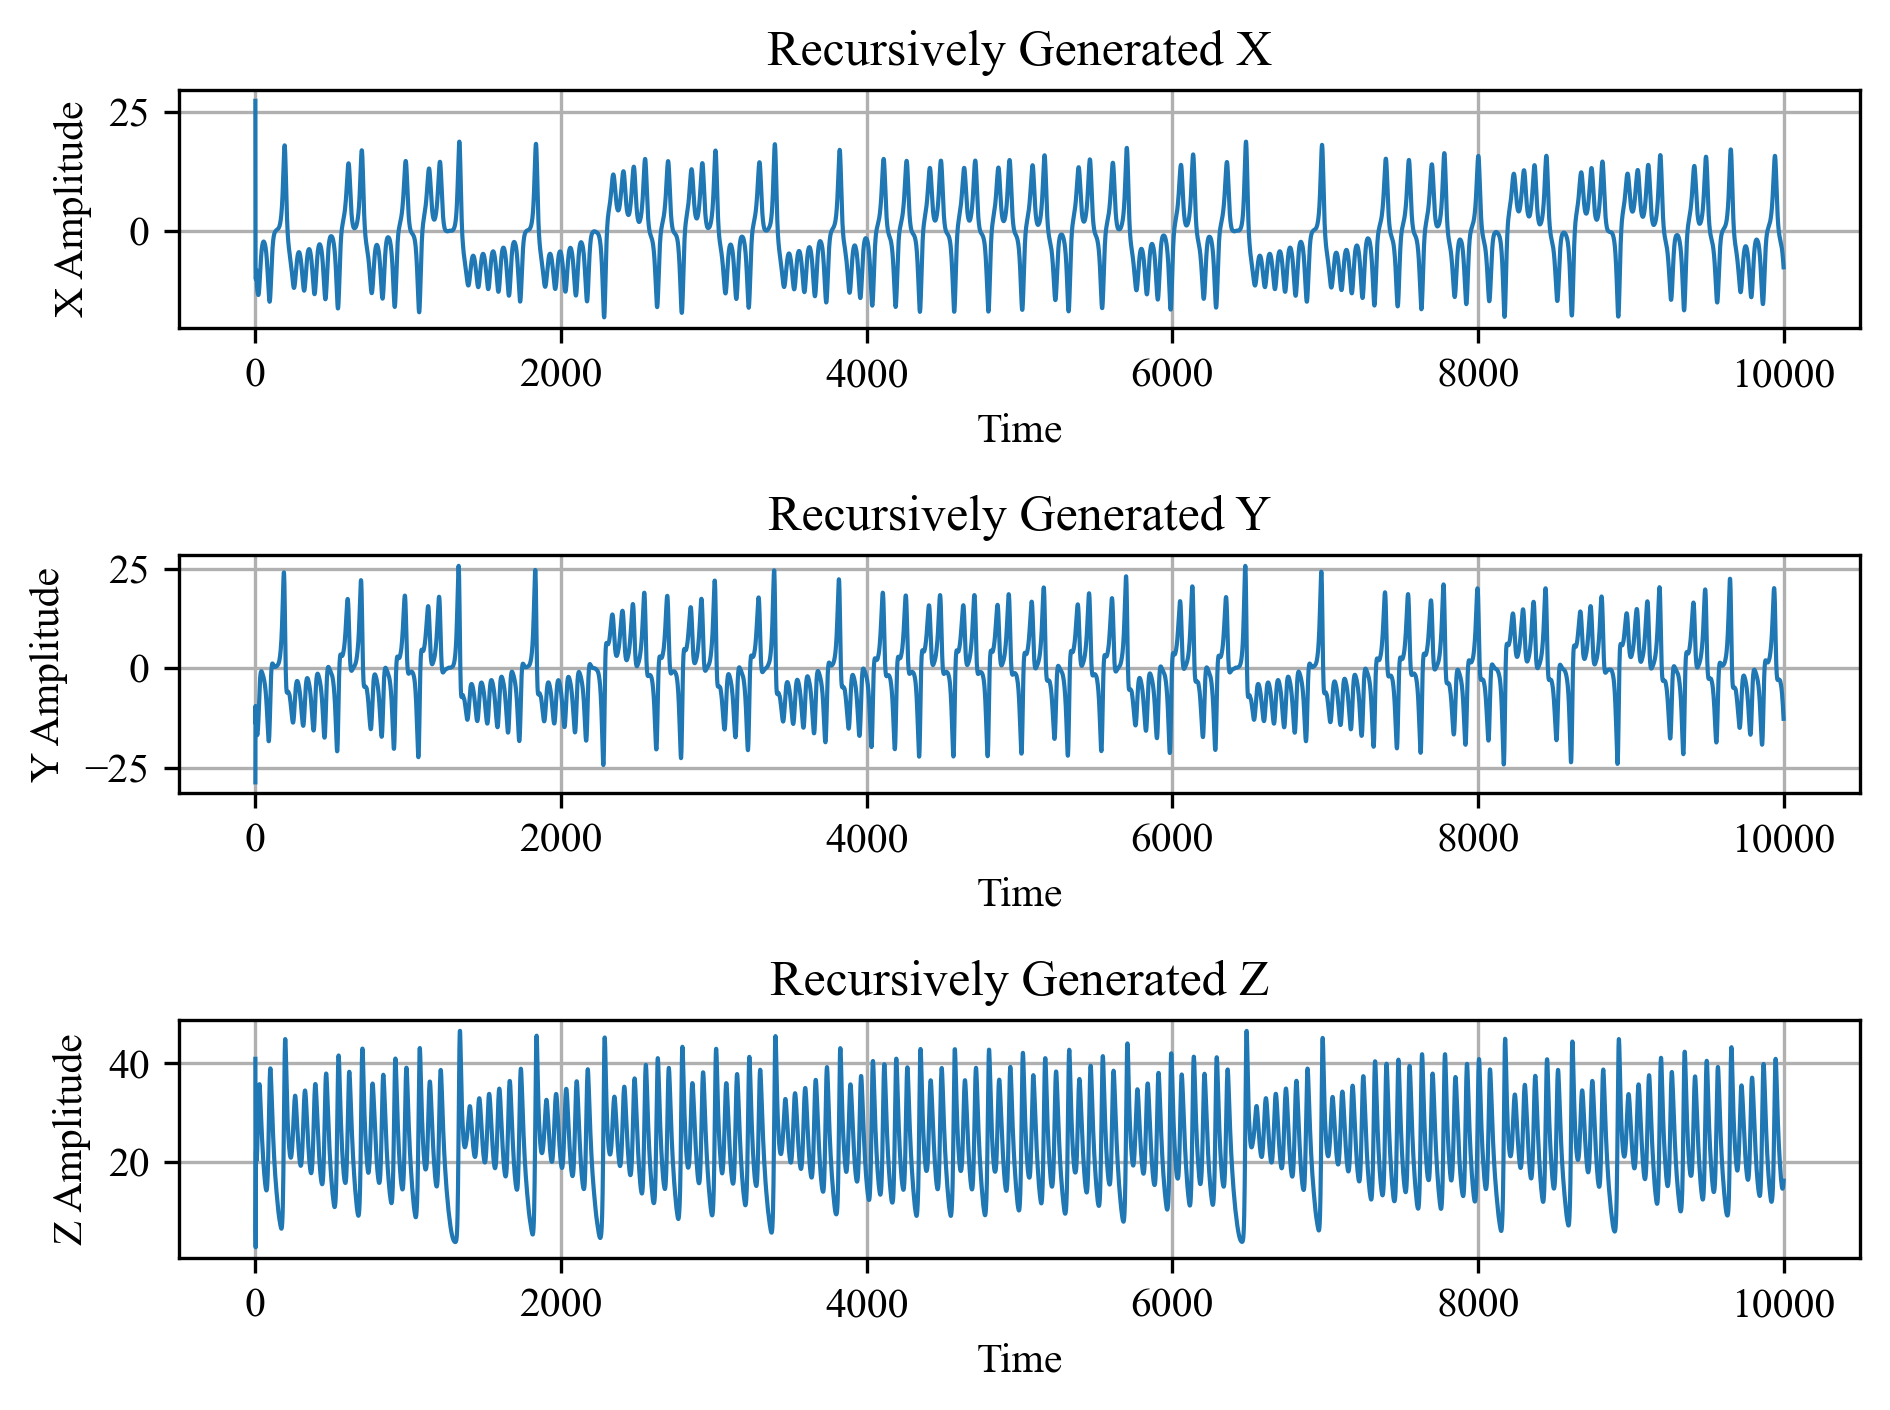

In [53]:
lorenz_ts_plotter(properly_scaled_output[0], properly_scaled_output[1], properly_scaled_output[2], np.arange(0, num_steps_to_generate), title_prefix="Recursively Generated ")

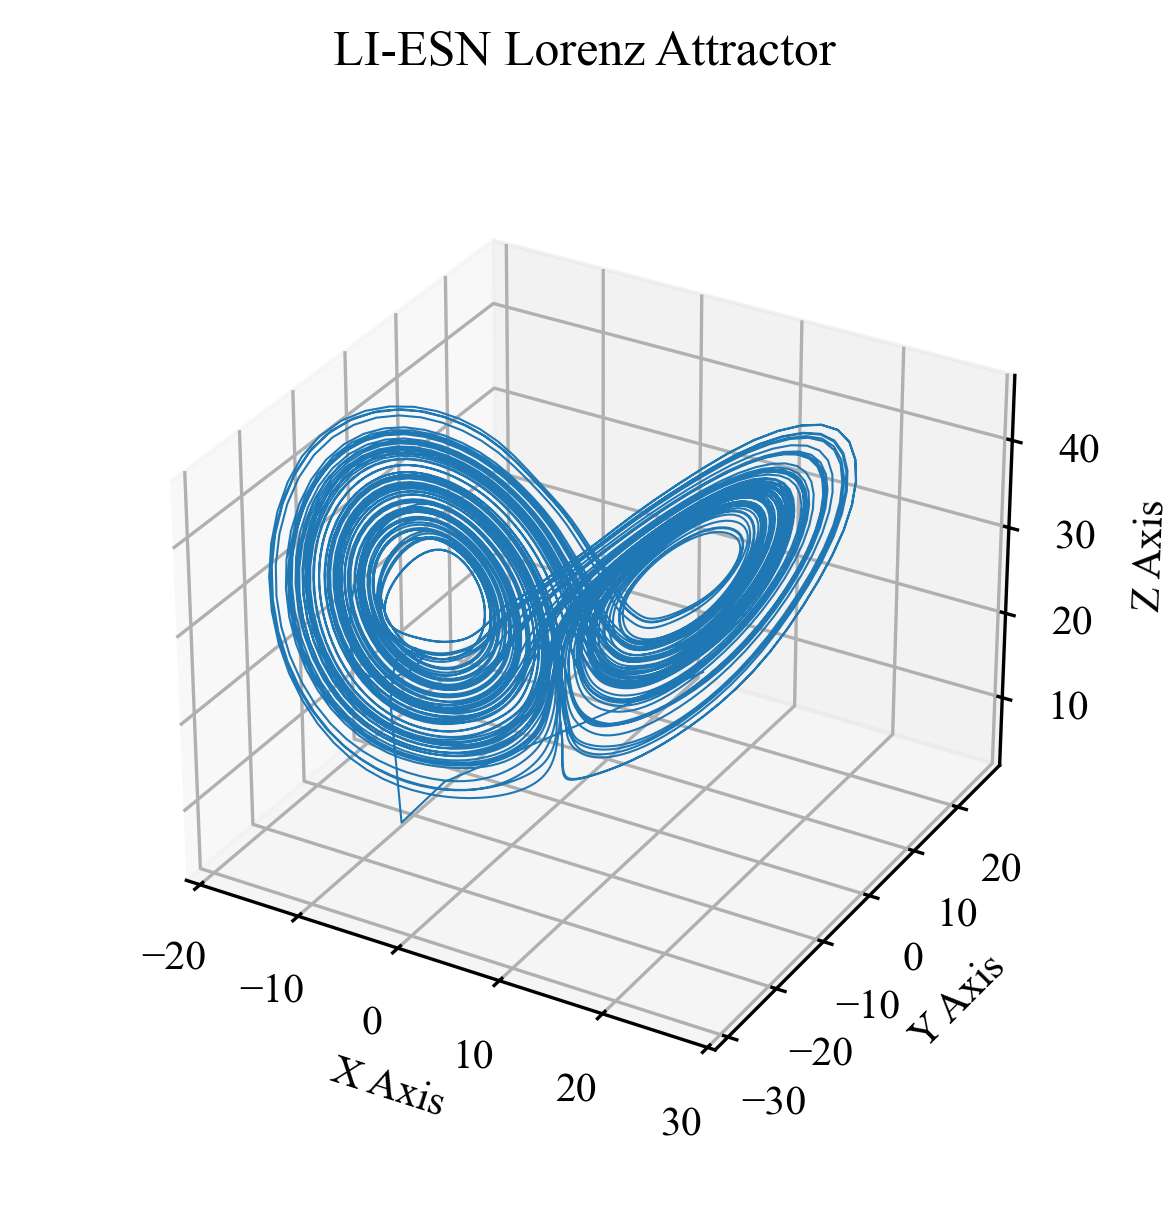

In [54]:
lorenz_3d_plotter(properly_scaled_output[0], properly_scaled_output[1], properly_scaled_output[2], title_prefix="LI-ESN ")